In [1]:
# ───────────────────────────────────────────────────────────────────────────────
# 📦 Standard Library Imports
# ───────────────────────────────────────────────────────────────────────────────
import os
import sys
import time
import csv
import json
from pathlib import Path

# ───────────────────────────────────────────────────────────────────────────────
# 📚 Scientific & Data Libraries
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 🌍 Third-Party Library Imports (PyTorch)
# ───────────────────────────────────────────────────────────────────────────────
import torch
import torch.optim as optim
import torchvision.transforms.functional as TF

# ───────────────────────────────────────────────────────────────────────────────
# 🧩 Custom Project Modules
# ───────────────────────────────────────────────────────────────────────────────
sys.path.append('C:/Users/nnobi/Desktop/FIUBA/Tesis/Project')

from project_package.utils import train_common_routines as tcr
from project_package.dataset_manager.webdataset_dataset import PtWebDataset

In [3]:
import tarfile
import torch
import matplotlib.pyplot as plt

def psnr(img1, img2, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    It calculates psnr across last 3 tensor dimensions. For example, if we have a batch of tensors, it will the mean psnr along for 
    each tensor in the batch
    """
    img1 = img1.clamp(0,1).cpu().detach().numpy()
    img2 = img2.clamp(0,1).cpu().detach().numpy()
    img_diff = img1 - img2
    rmse = np.sqrt(np.mean((img_diff) ** 2, axis=(-3,-2,-1)))
    PSNR = np.mean(20 * np.log10(max_val / rmse))
    return PSNR   

def mse(img1, img2):
    """
    Calcula el Mean Squared Error (MSE) entre dos tensores de imágenes.
    El MSE es el promedio del cuadrado de las diferencias por pixel.
    
    Soporta batches, calcula el MSE por cada tensor en el batch y devuelve la media.
    
    Args:
        img1, img2 (torch.Tensor): Tensores con forma (batch, canales, altura, ancho) o similar.
    
    Returns:
        float: MSE promedio para el batch.
    """
    img1 = img1.clamp(0, 1).cpu().detach().numpy()
    img2 = img2.clamp(0, 1).cpu().detach().numpy()
    mse_per_sample = np.mean((img1 - img2) ** 2, axis=(-3, -2, -1))
    return np.mean(mse_per_sample)

def plot_images_from_webdataset(dataset, num_batches=2, samples_per_row=4):
    """
    Muestra imágenes desde un WebDataset, con métricas PSNR y MSE entre pares de imágenes.

    Args:
        dataset (PtWebDataset): Instancia del dataset.
        num_batches (int): Número de batches a mostrar.
        samples_per_row (int): Cuántas imágenes por fila.
    """
    dataloader = dataset.get_dataloader(num_workers=0)
    batch_count = 0

    for inputs, targets in dataloader:
        batch_size = inputs.size(0)
        rows = 2
        cols = batch_size

        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

        for i in range(batch_size):
            input_tensor = inputs[i].unsqueeze(0)  # [1, C, H, W]
            target_tensor = targets[i].unsqueeze(0)  # [1, C, H, W]
            print(input_tensor.shape)
            # Upsample input to match target size
            input_resized = torch.nn.functional.interpolate(
                input_tensor, size=target_tensor.shape[-2:], mode='bicubic', align_corners=False
            )

            # Calcular métricas
            psnr_val = psnr(input_resized, target_tensor)
            mse_val = mse(input_resized, target_tensor)

            # Mostrar input (redimensionado)
            img_input = input_resized.squeeze(0).permute(1, 2, 0).cpu().numpy()
            axs[0, i].imshow(img_input)
            axs[0, i].axis("off")
            axs[0, i].set_title(f"Input\nPSNR: {psnr_val:.2f}\nMSE: {mse_val:.4f}")

            # Mostrar target
            img_target = target_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            axs[1, i].imshow(img_target)
            axs[1, i].axis("off")
            axs[1, i].set_title("Target")

        plt.tight_layout()
        plt.show()

        batch_count += 1
        if batch_count >= num_batches:
            break


c:\Users\nnobi\Desktop\FIUBA\Tesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029336669..1.0303802].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010424797..1.0209062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02370337..1.0020968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013474532..1.019246].


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


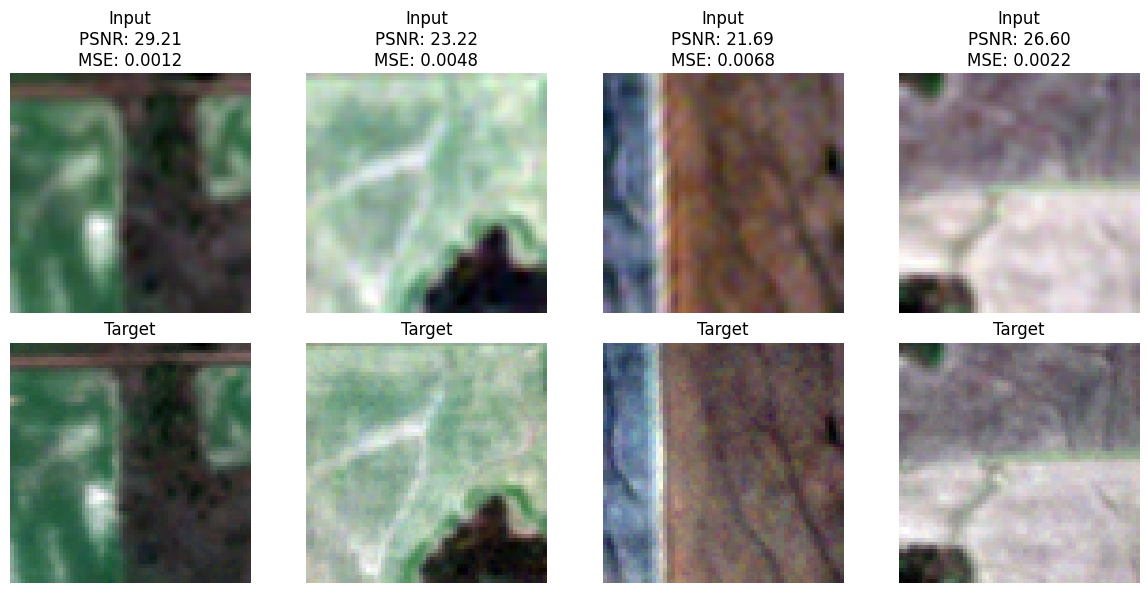

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.032625016..1.0120803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025158789..1.1118286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019660834..1.0130386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019094562..1.0281333].


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


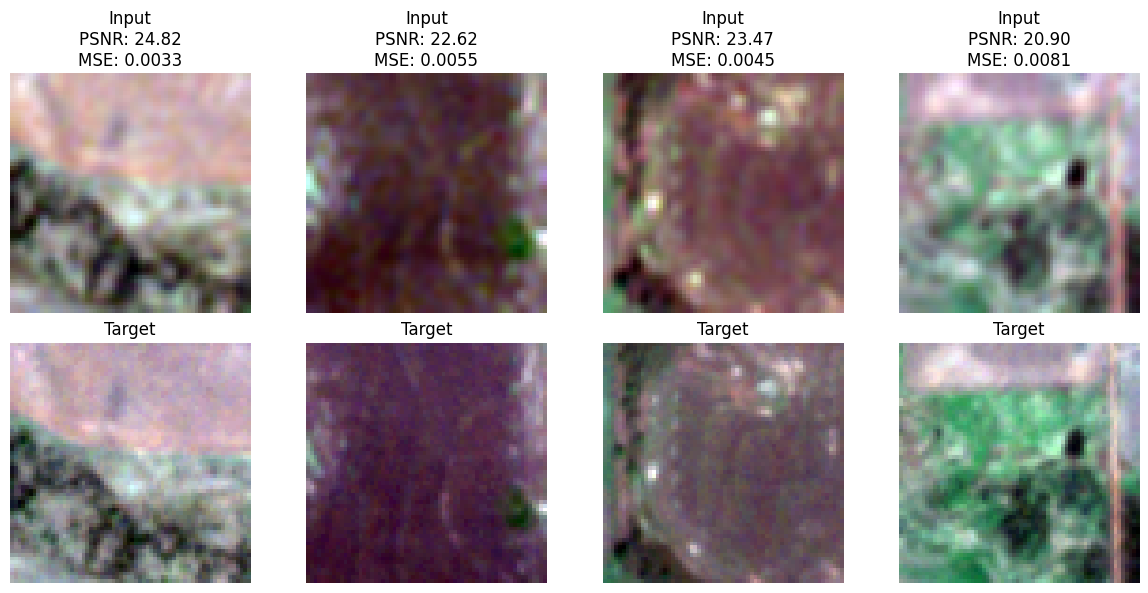

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057037488..1.0148175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03276039..1.1008888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033942655..1.0047517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024157856..1.0161706].


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


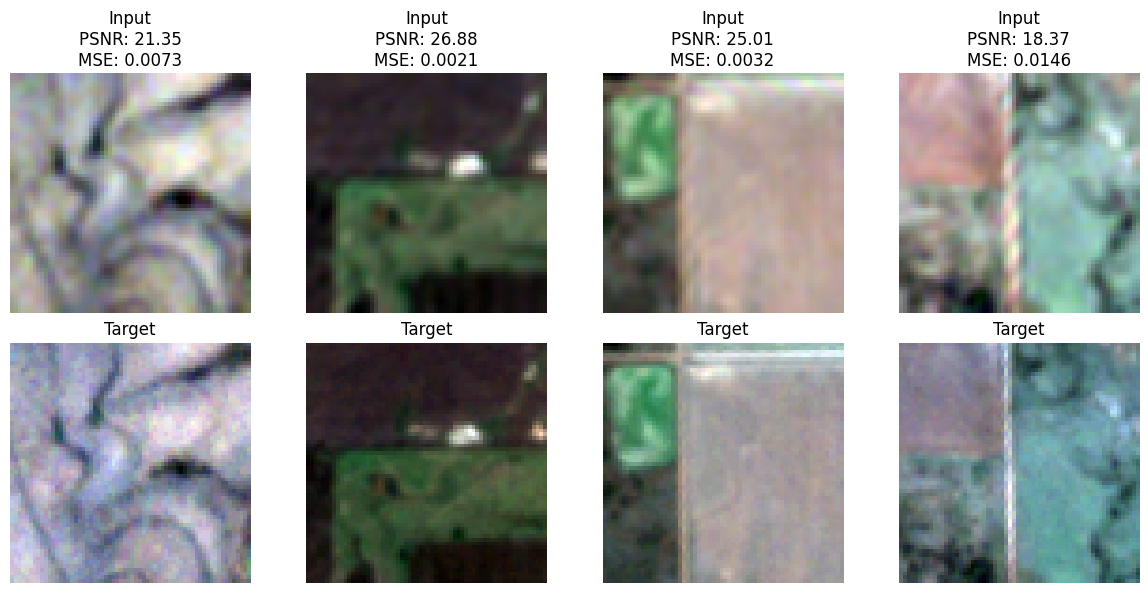

In [4]:
script_dir = script_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(script_dir, '..'))

dataset = 'Dataset_Campo' # Select Dataset
dataset_folder = os.path.join(project_dir, 'datasets', dataset)
metadata_path = os.path.join(dataset_folder, 'metadata.json')

import pathlib
dataset_folder = pathlib.Path(dataset_folder)

with open(metadata_path, "r") as f:
    metadata = json.load(f)


train_samples = metadata["splits"]["train"]["num_samples"]
val_samples = metadata["splits"]["val"]["num_samples"]
test_samples = metadata["splits"]["test"]["num_samples"]

dataset= PtWebDataset(os.path.join(dataset_folder,'train-*.tar'), length=train_samples, batch_size=4, shuffle_buffer=5 * 4)

# Mostrar imágenes y métricas
plot_images_from_webdataset(dataset, num_batches=3, samples_per_row=4)
